# Development - Pasiphae survey: sky field grid

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import cartopy.crs as ccrs
import cmasher as cms
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

## Development

### General functions

#### Visualization functions

##### Orthographic view

In [2]:
def create_orthographic_figure(central_longitude=15, central_latitude=45, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    projection = ccrs.Orthographic(central_longitude, central_latitude)
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_global()
    gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
            color='magenta', linestyle=':')
    gl.xlocator = MultipleLocator(30)
    gl.ylocator = MultipleLocator(15)
    
    return fig, ax

In [3]:
def plot_galactic_plane_orthographic(b_lim=30*u.deg, n=100):
    l = np.linspace(0, 360., n) * u.deg
    for sign in [-1, 1]:
        b = b_lim * sign * np.ones(l.shape[0])
        gcoord = SkyCoord(l=l, b=b, frame='galactic')
        coord = gcoord.fk5
        ax.plot(coord.ra.deg, coord.dec.deg, marker='None', color='0.5', linestyle='-', transform=ccrs.PlateCarree())

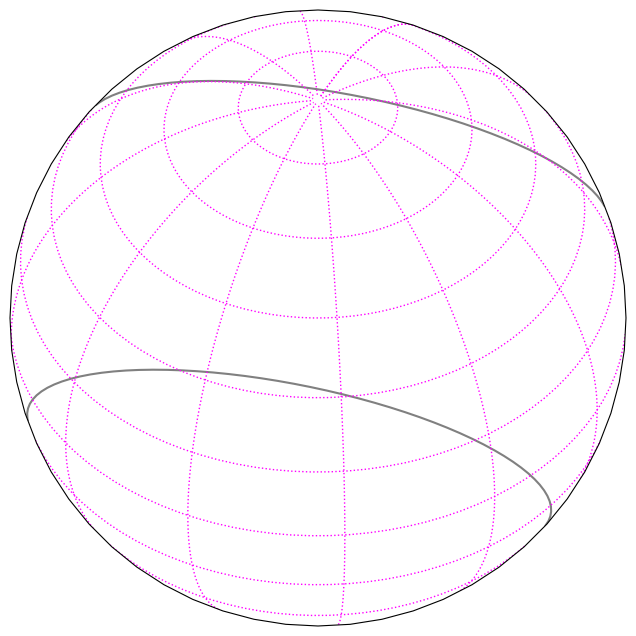

In [4]:
fig, ax = create_orthographic_figure(25, 45)
plot_galactic_plane_orthographic(n=101)

In [5]:
def plot_field_orthographic(fields, ax, **kwargs):
    if not isinstance(fields, list):
        fields = [fields]
        
    for field in fields:
        ra = np.degrees(np.r_[field[0], field[0][0]])
        dec = np.degrees(np.r_[field[1], field[1][0]])
        
        if np.any(np.diff(ra) > 180.):
            ra = np.where(ra > 180., ra - 360., ra)
            
        ax.plot(ra ,dec, transform=ccrs.PlateCarree(), **kwargs)

##### Mollweide view

In [6]:
def create_mollweide_figure(figsize=(16, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='mollweide')
    ax.grid(True, color='magenta', linestyle=':')
    
    return fig, ax

In [7]:
def plot_galactic_plane_mollweide(b_lim=10*u.deg, n=100):
    
    l = np.linspace(0, 360., n+1)
    l = np.r_[l, l[1]] 
    l *= u.deg
    
    for sign in [-1, 1]:
        b = sign * b_lim * np.ones(l.shape[0])
        gcoord = SkyCoord(l=l, b=b, frame='galactic')
        coord = gcoord.fk5
        ra = np.where(coord.ra.rad > np.pi, coord.ra.rad - 2. * np.pi, coord.ra.rad)
        dec = coord.dec.rad
        
        i_wrap = np.nonzero(np.absolute(np.diff(ra)) > np.pi)[0]
        i_wrap = [0] + list(i_wrap + 1) + [-1]
 
        for i, j in zip(i_wrap[:-1], i_wrap[1:]):
            ax.plot(ra[i:j], dec[i:j], marker='None', color='0.5', linestyle='-')

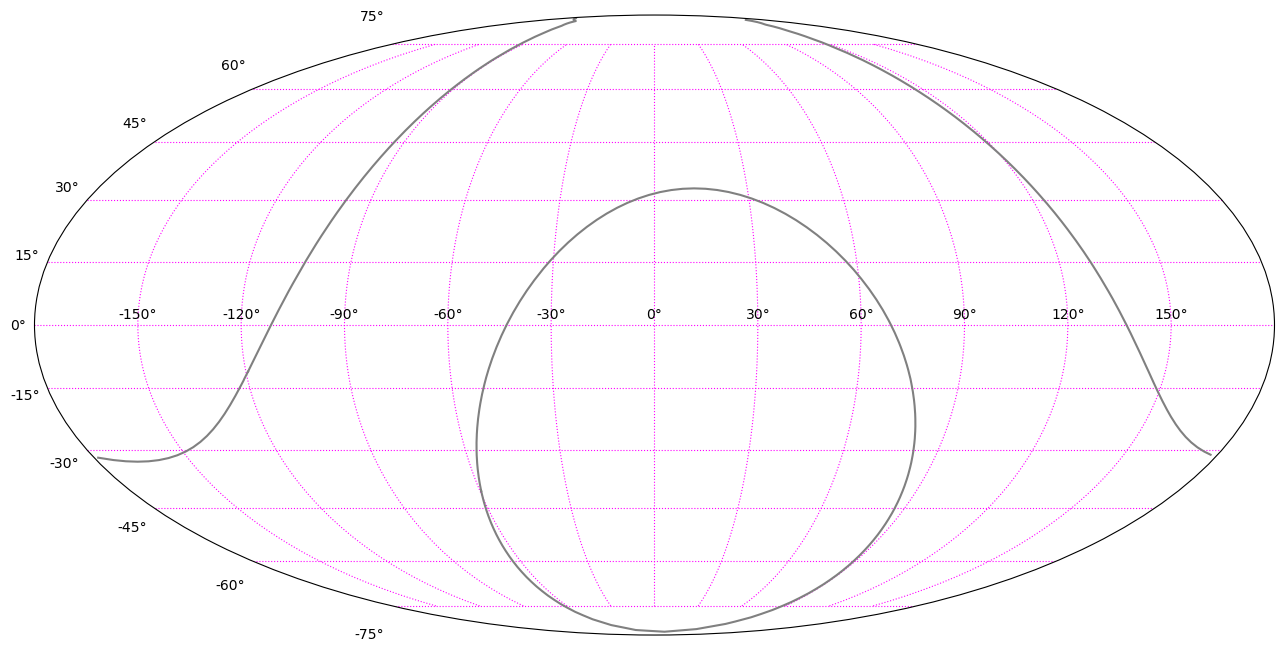

In [8]:
fig, ax = create_mollweide_figure()
plot_galactic_plane_mollweide(b_lim=30*u.deg, n=100)

In [9]:
def plot_field_mollweide(fields, ax, **kwargs):
    if not isinstance(fields, list):
        fields = [fields]
        
    for field in fields:
        ra = np.r_[field[0], field[0][0]]
        ra = np.where(ra > np.pi, ra - np.pi * 2., ra)
        dec = np.r_[field[1], field[1][0]]
        
        # plot wrapping fields:
        if ra[0] > 0 and ra[1] < 0:
            # plot right part:
            ax.plot([np.pi, ra[0], ra[0], np.pi], [dec[2], dec[2], dec[0], dec[0]], **kwargs)

            # plot left part:
            ax.plot([-np.pi, ra[1], ra[1], -np.pi], [dec[2], dec[2], dec[0], dec[0]], **kwargs)

        # plot non-wrapping fields:
        else:
            ax.plot(ra, dec, **kwargs)

#### Coordinate transformations

##### Spherical to cartesian and vice versa

Note: astropy provides the two functions `cartesian_to_spherical()` and `spherical_to_cartesian()`. However, they add the overhead of returning `astropy.units.Quantity` instances. Therefore, I am going to use my own simple numpy array based implementation.

In [10]:
def cart_to_sphere(x, y, z):
    """Transform cartesian to spherical coordinates."""
    
    r = np.sqrt(x**2 + y**2 + z**2)
    za = np.arccos(z / r)
    dec = np.pi / 2. - za
    ra = np.arctan2(y, x)
    ra = np.mod(ra, 2*np.pi)
    
    return ra, dec, r

In [11]:
def sphere_to_cart(ra, dec):
    """Transform spherical to cartesian coordinates."""
    
    za = np.pi / 2. - dec
    x = np.sin(za) * np.cos(ra)
    y = np.sin(za) * np.sin(ra)
    z = np.cos(za)
    
    return x, y, z

Check that everything is transformed back to the correct quarters:

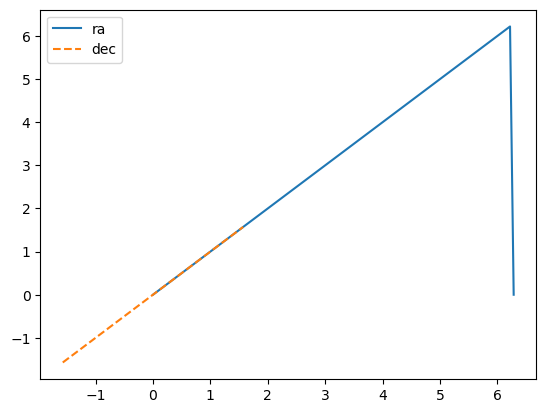

In [12]:
ra = np.linspace(0, 2*np.pi, 100)
dec = np.linspace(-np.pi/2, np.pi/2, ra.shape[0])

x, y, z = sphere_to_cart(ra, dec)
ra_back, dec_back, __ = cart_to_sphere(x, y, z)

plt.plot(ra, ra_back, ls='-', label='ra')
plt.plot(dec, dec_back, ls='--', label='dec')
plt.legend();

##### Rotations

Rotation around the x-axis for the case that the CCD is slightly tilted:

In [13]:
def rot_tilt(x, y, z, tilt):
    """Rotate around x-axis by tilt angle."""
    
    x_rot = x 
    y_rot = y * np.cos(tilt) - z * np.sin(tilt)
    z_rot = y * np.sin(tilt) + z * np.cos(tilt)
    
    return x_rot, y_rot, z_rot

Rotation around the y-axis to reach the target declination:

In [14]:
def rot_dec(x, y, z, dec):
    """Rotate around y-axis by declination angle."""
    
    dec = -dec
    x_rot = x * np.cos(dec) + z * np.sin(dec)
    y_rot = y
    z_rot = -x * np.sin(dec) + z * np.cos(dec)
    
    return x_rot, y_rot, z_rot

Rotation around the z-axis to reach the targeted RA:

In [15]:
def rot_ra(x, y, z, ra):
    """Rotate around z-axis by right ascension angle."""
    
    x_rot = x * np.cos(ra) - y * np.sin(ra)
    y_rot = x * np.sin(ra) + y * np.cos(ra)
    z_rot = z
    
    return x_rot, y_rot, z_rot

### Calculate field corner points

A *field* is rectangular has a center point and a width given by the field of view (FoV). For the visualization we calculate the coordinates of the four corner points. In different projections four points may not be enough to represent the shape of the field adequately, but as the simplest approximatio it will suffice.

We start in cartesian coordinates. We define the position of the four corner points. Then we rotate around the y-axis to move to the targeted declination. Then we rotate around the z-axis to rotate to the targeted right ascension (RA). Finally, we transform to spherical coordinates, i.e. RA, dec.

Field corner points: We initiate the field at center point $(1, 0, 0)$. We define the corner points in the $x=1$-plane. For a FoV angle `fov` we need to move from the center point by $\pm\tan(\mathrm{fov}/2)$ in the y- and z-plane to reach the corner points. Note we are not on the unit-sphere. Projection onto the unit-sphere will be done later, simply by ignoring the radius.

In [16]:
def field_corners_init(fov):
    """Create field corner points in cartesian coordinates."""
    
    diff = np.tan(fov / 2.)
    x = np.ones(4)
    y = np.array([-diff, diff, diff, -diff])
    z = np.array([-diff, -diff, diff, diff])
    
    return x, y, z

Field rotations: We rotate the initial field corners. First, the tilt; second, the declination; third, the right ascension. This gives us the final field corner points.

In [17]:
def field_corners(fov, ra=0., dec=0., tilt=0.):
    """Create field corner points at specified field center coordinates."""
    
    ra = np.mod(ra, 2.*np.pi)
    
    if dec > np.pi / 2.:
        raise ValueError("Declination cannot be higher than pi/2")
    if dec < -np.pi / 2.:
        raise ValueError("Declination cannot be lower than -pi/2")
    
    x, y, z = field_corners_init(fov)
    x, y, z = rot_tilt(x, y, z, tilt)
    x, y, z = rot_dec(x, y, z, dec)
    x, y, z = rot_ra(x, y, z, ra)
    ra, dec, __ = cart_to_sphere(x, y, z)
    
    return ra, dec

In [18]:
fov = np.radians(10.) # rad
tilt = np.radians(20.) # rad
dec = np.radians(60.) # rad
ra = np.radians(60.) # rad

field0 = field_corners(fov)
field1 = field_corners(fov, tilt=tilt)
field2 = field_corners(fov, tilt=tilt, dec=dec)
field3 = field_corners(fov, tilt=tilt, dec=dec, ra=ra)

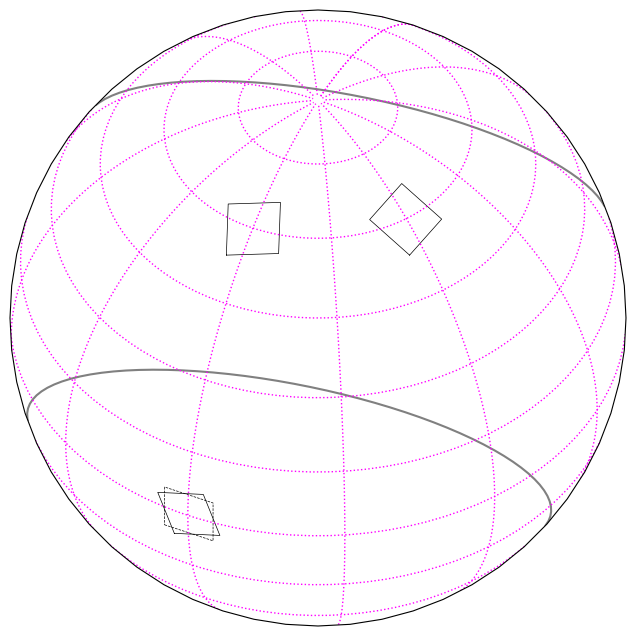

In [19]:
fig, ax = create_orthographic_figure(25, 45)
plot_galactic_plane_orthographic(n=101)
plot_field_orthographic(field0, ax, color='k', ls='--', lw=0.5)
plot_field_orthographic(field1, ax, color='k', ls='-', lw=0.5)
plot_field_orthographic(field2, ax, color='k', ls='-', lw=0.5)
plot_field_orthographic(field3, ax, color='k', ls='-', lw=0.5)

#### Field edges

For visualizing field outlines more accurately we extend the above functions to include some more points between the corner points. For instance in Dec-vs-RA plots the edges are not linear connections between the corner points and deviate from that the further the field is located off the equator.

In [20]:
def field_edges_init(fov, n=10):
    """Create field corner points in cartesian coordinates."""
    
    diff = np.tan(fov / 2.)
    x = np.ones(n*4)
    y = np.concatenate([
            np.linspace(-diff, diff, n+1)[:-1],
            np.linspace(diff, diff, n+1)[:-1],
            np.linspace(diff, -diff, n+1)[:-1],
            np.linspace(-diff, -diff, n+1)[:-1]])
    z = np.concatenate([
            np.linspace(-diff, -diff, n+1)[:-1],
            np.linspace(-diff, diff, n+1)[:-1],
            np.linspace(diff, diff, n+1)[:-1],
            np.linspace(diff, -diff, n+1)[:-1]])
    
    return x, y, z

In [21]:
def field_edges(fov, ra=0., dec=0., tilt=0., n=10):
    """Create field corner points at specified field center coordinates."""
    
    ra = np.mod(ra, 2.*np.pi)
    
    if dec > np.pi / 2.:
        raise ValueError("Declination cannot be higher than pi/2")
    if dec < -np.pi / 2.:
        raise ValueError("Declination cannot be lower than -pi/2")
    
    x, y, z = field_edges_init(fov, n=n)
    x, y, z = rot_tilt(x, y, z, tilt)
    x, y, z = rot_dec(x, y, z, dec)
    x, y, z = rot_ra(x, y, z, ra)
    ra, dec, __ = cart_to_sphere(x, y, z)
    ra = np.mod(ra, 2. * np.pi)
    
    return ra, dec

### Field grids

#### Isolatitudinal grid

**Grid layout:**

1. We split the declination range into equidistant steps. 
2. At each declination we place a circle parallel to the equator. 
3. Each cicle is split into a certain number of fields at different right ascensions.

##### Split circle of constant declination

For simplicity we start with step 3 at the equator. We split the equator into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov}}\right)$ fields:

In [22]:
fov = np.radians(10.) # radians

n = int(np.ceil(2 * np.pi / fov))
print(f'Number of fields: {n}')

Number of fields: 36


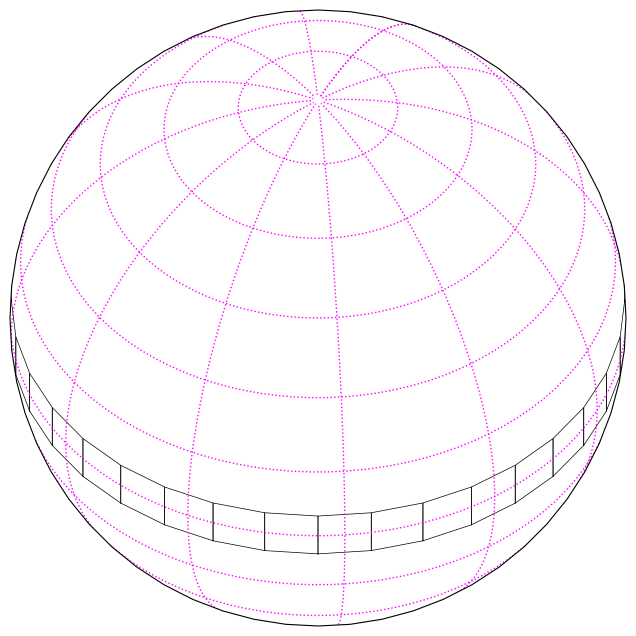

In [23]:
ras = np.arange(0., 2.*np.pi, fov)

fig, ax = create_orthographic_figure(25, 45)

for ra in ras:
    field = field_corners(fov, ra=ra, dec=0., tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

Next we allow for an overlap between neighboring fields. If the overlap leads to an integer number of fields we use that number of fields. If the overlap does not result in an interger number, we use the next highest integer and increase the overlap accordingly. This way we equally distribute the overlap over all fields and do not end up with a much larger overlap between the pair of the first and last field around the equator. We split the equator into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov} - \mathrm{overlap}}\right)$ fields:

Number of fields: 45
Overlap used: 2.00 deg


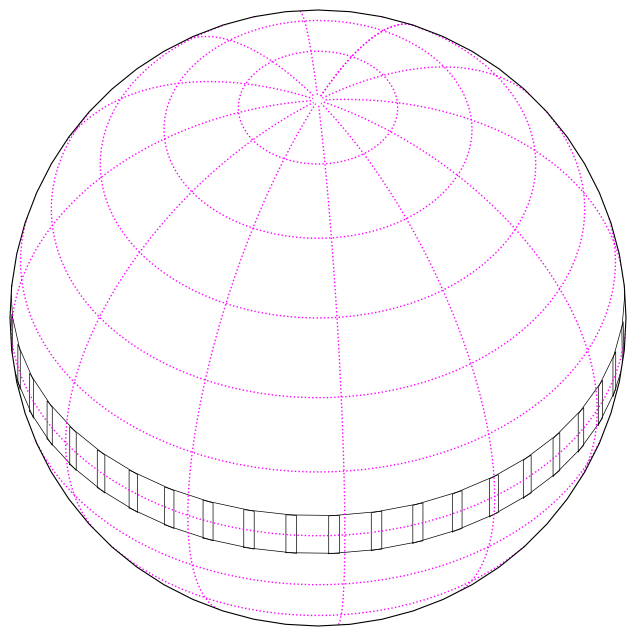

In [24]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
overlap_used = fov - (ras[1] - ras[0])
print('Overlap used: {0:.2f} deg'.format(np.degrees(overlap_used)))

fig, ax = create_orthographic_figure(25, 45)

for ra in ras:
    field = field_corners(fov, ra=ra, dec=0., tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

Above we have split the equator into fields. At the equator the circumfence is $c = 2 \pi r$ with radius $r = 1$. At any declination $\delta$ the radius is $r = \cos \delta$. Accordingly, we split the circle at declination $\delta$ into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov} - \mathrm{overlap}} \cos \delta\right)$ fields:

Declination: 30.0 deg
Number of fields: 38


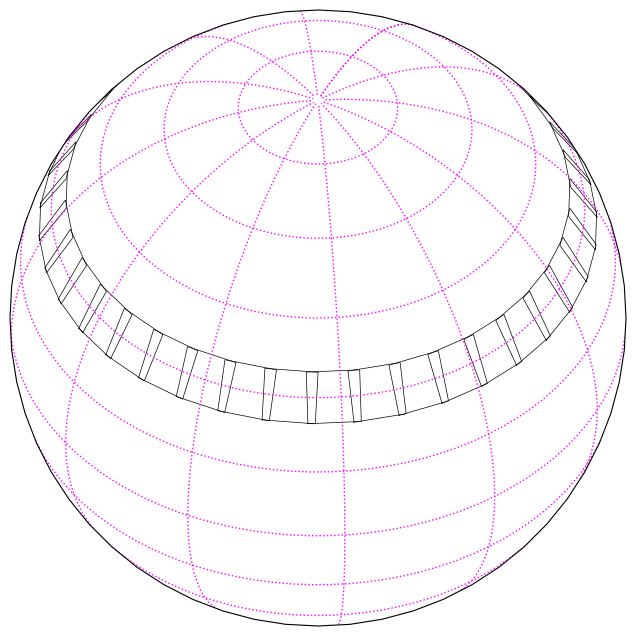

In [25]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec = np.radians(30.) # radians
print('Declination: {0:.1f} deg'.format(np.degrees(dec)))

n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]

fig, ax = create_orthographic_figure(25, 45)

for ra in ras:
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

Declination: 60.0 deg
Number of fields: 22


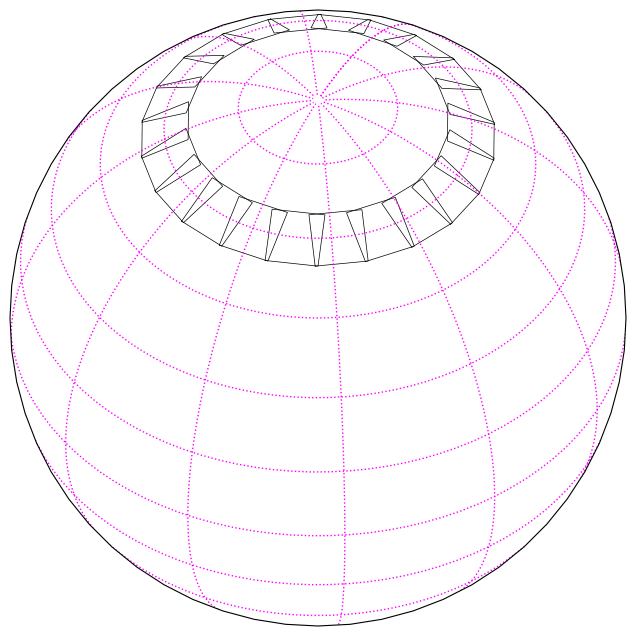

In [26]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec = np.radians(60.) # radians
print('Declination: {0:.1f} deg'.format(np.degrees(dec)))

n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
print(f'Number of fields: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]

fig, ax = create_orthographic_figure(25, 45)

for ra in ras:
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

<div class="alert alert-block alert-danger">
This scheme only works (a) when an overlap is defined, otherwise there will be a gap between the lower corners of adjacent fields, and (b) only up to a certain declination, which depends on the FoV and the overlap. Two changes/additions are needed: (1) Ensure no gaps! (2) It would be very useful to calculate the amount of actual overlap, which will differ from the case at the equator.
</div>

We implement the above in a function that returns the center coordinates. Note that we add the special case of $\delta = \pm 90.$, which would not result in a field with the above code:

In [27]:
def field_centers_along_dec(fov, overlap=0., dec=0., verbose=0, n_min=3):
    """Calaculate the center coordinates for each field along a circle at a given declination."""
    
    if np.isclose(np.absolute(dec), np.pi/2.):
        n = 1
        ras = [0]
    
    else:
        n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
        if n < n_min:
            n = n_min
        ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
        
    decs = np.ones(n) * dec
    
    if verbose > 2:
        print(f'Dec: {np.degrees(dec):+6.2f} deg. Number of fields: {n:4d}')
    
    return ras, decs

##### Split declination range

Next, we split the declination range into steps at which the circles should be created.

We may want to define two declination limits, a Northern limit, $\delta_N$, and a Southern limit $\delta_S$. If not, the limits are $\delta_N=90^\circ, \delta_S=-90^\circ$. The declination to cover then is $\Delta\delta = \delta_N - \delta_S$.

When $\Delta\delta$ is a multiple of the field of view, $\mathrm{fov}$, the number of declination steps needed is simply $n = \Delta\delta / \mathrm{fov}$ and the declination of the lowest field's center point is $\delta_S + \mathrm{fov}/2$.

We need to generalize this, when the declination range is not a multiple of the field of view. Then, the number of declination steps is $n = \mathrm{ceil}(\Delta\delta / \mathrm{fov}))$. In the general case the actual declination range $\Delta\delta^* = n \times \mathrm{fov} \geq \Delta\delta$. We want to arange the extended declination range such that the same extenstion is applied in the North as in the South. The total extension is $\Delta\delta^* - \Delta\delta$, and the extension in each direction therefore is, $\epsilon_\delta = (\Delta\delta^* - \Delta\delta) / 2$. We use $\epsilon_\delta$ as an offset to the field's center points. The declination of the lowest field's center point is $\delta_S + \mathrm{fov}/2 - \epsilon_\delta$.

Finally, we want to allow for an overlap, $\mathrm{overlap}$, as we did in the fixed-declination circles above. Now, the number of declination steps is $n = \mathrm{ceil}((\Delta\delta - \mathrm{overlap}) / (\mathrm{fov} - \mathrm{overlap}))$. The actual declination range is $\Delta\delta^* = n \times (\mathrm{fov} - \mathrm{overlap}) + \mathrm{overlap}$. The extension of the declination range in both directions remains $\epsilon_\delta = (\Delta\delta^* - \Delta\delta) / 2$ and the declination of the lowest field's center point remains $\delta_S + \mathrm{fov}/2 - \epsilon_\delta$.

In [28]:
def split_declination(fov, overlap=0, dec_lim_north=np.pi/2., dec_lim_south=-np.pi/2., verbose=0):
    dec_range = dec_lim_north - dec_lim_south
    field_range = fov - overlap
    n = (dec_range - overlap) / field_range
    
    # round when n (almost) is an interger number:
    if np.isclose(np.mod(n, 1), 0):
        n = int(np.round(n))
    # otherwise ceil:
    else:
        n = int(np.ceil(n))
    
    if verbose > 1:
        print(f'Number of declination circles: {n}')
    
    dec_range_real = n * field_range + overlap
    offset = (dec_range_real - dec_range) / 2.
    dec0 = dec_lim_south + fov / 2. - offset
    dec1 = dec0 + field_range * (n - 1)
    declinations = np.linspace(dec0, dec1, n)
    
    return declinations

In [29]:
fov = np.radians(10.) # radians
overlap = np.radians(0.) # radians
dec_lim_north = np.radians(60.) # radians
dec_lim_south = np.radians(30.) # radians

decs = split_declination(fov, overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=2)
np.degrees(decs)

Number of declination circles: 3


array([35., 45., 55.])

In [30]:
fov = np.radians(10.) # radians
overlap = np.radians(0.) # radians
dec_lim_north = np.radians(60.) # radians
dec_lim_south = np.radians(25.) # radians

decs = split_declination(fov, overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=2)
np.degrees(decs)

Number of declination circles: 4


array([27.5, 37.5, 47.5, 57.5])

In [31]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(60.) # radians
dec_lim_south = np.radians(30.) # radians

decs = split_declination(fov, overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=2)
np.degrees(decs)

Number of declination circles: 4


array([33., 41., 49., 57.])

Finally, we combine all of the above in one function:

In [32]:
def field_centers_eq(fov, overlap=0., dec_lim_north=np.pi/2., dec_lim_south=-np.pi/2., verbose=0):
    """Iterator that yield the corner coordinates for each field along a circle at a given declination."""
    
    if dec_lim_north > np.pi / 2.:
        raise ValueError("Northern declination limit cannot exceed pi/2.")
    if dec_lim_south < -np.pi / 2.:
        raise ValueError("Southern declination limit cannot exceed -pi/2.")

    declinations = split_declination(fov, overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=2)
    center_ra = []
    center_dec = []
    
    for decs in declinations:
        ra, dec = field_centers_along_dec(fov, overlap=overlap, dec=decs, verbose=verbose)
        center_ra.append(ra)
        center_dec.append(dec)
    
    center_ra = np.concatenate(center_ra)
    center_dec = np.concatenate(center_dec)

    if verbose > 0:
        print(f'Total number of fields: {center_ra.size}')
        
    return center_ra, center_dec

<div class="alert alert-block alert-danger">
This setup of the declination steps is not implemented in the `skyfields.py` module yet. It still has the old version and needs to be updated.
</div>

In [33]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-90.) # radians

center_ra, center_dec = field_centers_eq(fov, overlap=overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=3)

Number of declination circles: 23
Dec: -88.00 deg. Number of fields:    3
Dec: -80.00 deg. Number of fields:    7
Dec: -72.00 deg. Number of fields:   13
Dec: -64.00 deg. Number of fields:   19
Dec: -56.00 deg. Number of fields:   25
Dec: -48.00 deg. Number of fields:   30
Dec: -40.00 deg. Number of fields:   34
Dec: -32.00 deg. Number of fields:   38
Dec: -24.00 deg. Number of fields:   41
Dec: -16.00 deg. Number of fields:   43
Dec:  -8.00 deg. Number of fields:   44
Dec:  -0.00 deg. Number of fields:   45
Dec:  +8.00 deg. Number of fields:   44
Dec: +16.00 deg. Number of fields:   43
Dec: +24.00 deg. Number of fields:   41
Dec: +32.00 deg. Number of fields:   38
Dec: +40.00 deg. Number of fields:   34
Dec: +48.00 deg. Number of fields:   30
Dec: +56.00 deg. Number of fields:   25
Dec: +64.00 deg. Number of fields:   19
Dec: +72.00 deg. Number of fields:   13
Dec: +80.00 deg. Number of fields:    7
Dec: +88.00 deg. Number of fields:    3
Total number of fields: 639


<div class="alert alert-block alert-danger">
The North pole region may not be covered completely. This needs to be checked.
</div>

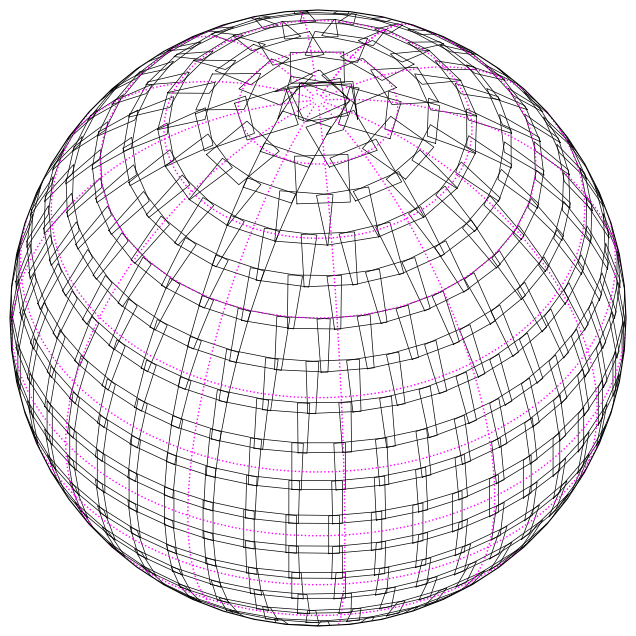

In [34]:
fig, ax = create_orthographic_figure(25, 45)

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

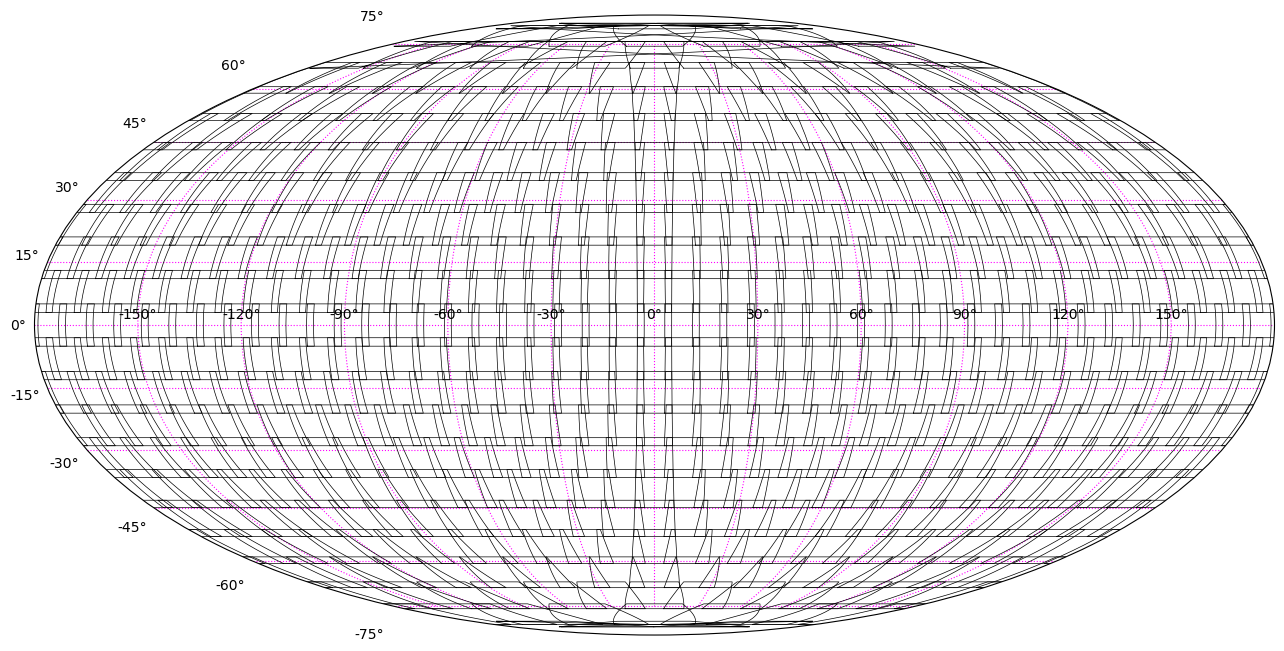

In [35]:
fig, ax = create_mollweide_figure()

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_mollweide(field, ax, color='k', ls='-', lw=0.5)

<div class="alert alert-block alert-warning">
Plotting of the fields is messed up when the fields includes the North pole in both projections. I am going to ignore this for now.
</div>

##### Fix gaps at higher declinations

The above plot shows that we get gaps near the poles. The reason is that neighboring fields are more and more titled relative to another, the closer we get to the pole. Where exactly this happens depends on the field size. Increasing the amount of overlap can reduce gaps, maybe avoid gaps. However, (1) it is not straight forward how much overlap we need for a specific field size to avoid gaps and (2) the amoung of overlap should be decided by the purpose for the reduction and quality checks, not the field setup.

In the following we will remove the gaps by increasing the number of fields at declinations, where gaps occur with the current setup.

In [36]:
def close_gaps(decs, ras, n, fov, overlap, dec, tilt):
    
    # get first two field's corners:
    field0_corner_ras, field0_corner_decs = field_corners(fov, tilt=tilt, dec=decs[0], ra=ras[0])
    field1_corner_ras, field1_corner_decs = field_corners(fov, tilt=tilt, dec=decs[1], ra=ras[1])
    
    # select two field corners - fields in the South:
    if field0_corner_decs[0] < 0.:
        i = 2
        j = 3
        
    # select two field corners - fields in the North:
    else:
        i = 1
        j = 0
        
    ra0 = field0_corner_ras[i]
    ra1 = field1_corner_ras[j]
    
    # increase number of fields until gaps are removed:
    while ra0 < ra1:
        n += 1
        ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
        decs = np.ones(n) * dec

        ra0 = field_corners(fov, tilt=tilt, dec=decs[0], ra=ras[0])[0][i]
        ra1 = field_corners(fov, tilt=tilt, dec=decs[1], ra=ras[1])[0][j]
    
    return ras, decs, n

In [37]:
def field_centers_along_dec(fov, overlap=0., dec=0., tilt=0., verbose=0, n_min=3):
    """Calaculate the center coordinates for each field along a circle at a given declination."""
    
    if np.isclose(np.absolute(dec), np.pi/2.):
        n = 1
        ras = np.array([0])
        decs = np.array([dec])
    
    else:
        n = int(np.ceil(2 * np.pi / (fov - overlap)) * np.cos(dec))
        if n < n_min:
            n = n_min
        ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
        decs = np.ones(n) * dec
    
        ras, decs, n = close_gaps(decs, ras, n, fov, overlap, dec, tilt)
    
    if verbose > 2:
        print(f'Dec: {np.degrees(dec):+6.2f} deg. Number of fields: {n:4d}')
    
    return ras, decs

In [38]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-90.) # radians

center_ra, center_dec = field_centers_eq(fov, overlap=overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=3)

Number of declination circles: 23
Dec: -88.00 deg. Number of fields:    6
Dec: -80.00 deg. Number of fields:   10
Dec: -72.00 deg. Number of fields:   15
Dec: -64.00 deg. Number of fields:   19
Dec: -56.00 deg. Number of fields:   25
Dec: -48.00 deg. Number of fields:   30
Dec: -40.00 deg. Number of fields:   34
Dec: -32.00 deg. Number of fields:   38
Dec: -24.00 deg. Number of fields:   41
Dec: -16.00 deg. Number of fields:   43
Dec:  -8.00 deg. Number of fields:   44
Dec:  -0.00 deg. Number of fields:   45
Dec:  +8.00 deg. Number of fields:   44
Dec: +16.00 deg. Number of fields:   43
Dec: +24.00 deg. Number of fields:   41
Dec: +32.00 deg. Number of fields:   38
Dec: +40.00 deg. Number of fields:   34
Dec: +48.00 deg. Number of fields:   30
Dec: +56.00 deg. Number of fields:   25
Dec: +64.00 deg. Number of fields:   19
Dec: +72.00 deg. Number of fields:   15
Dec: +80.00 deg. Number of fields:   10
Dec: +88.00 deg. Number of fields:    6
Total number of fields: 655


<div class="alert alert-block alert-danger">
The North pole region may not be covered completely. This needs to be checked.
</div>

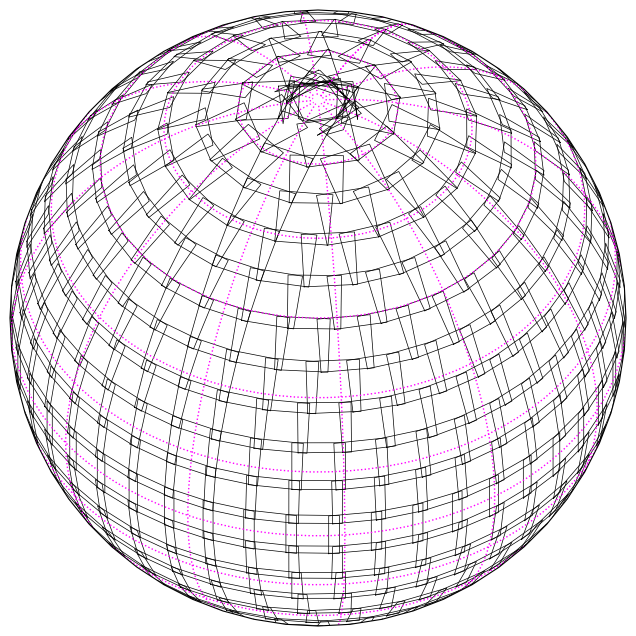

In [39]:
fig, ax = create_orthographic_figure(25, 45)

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

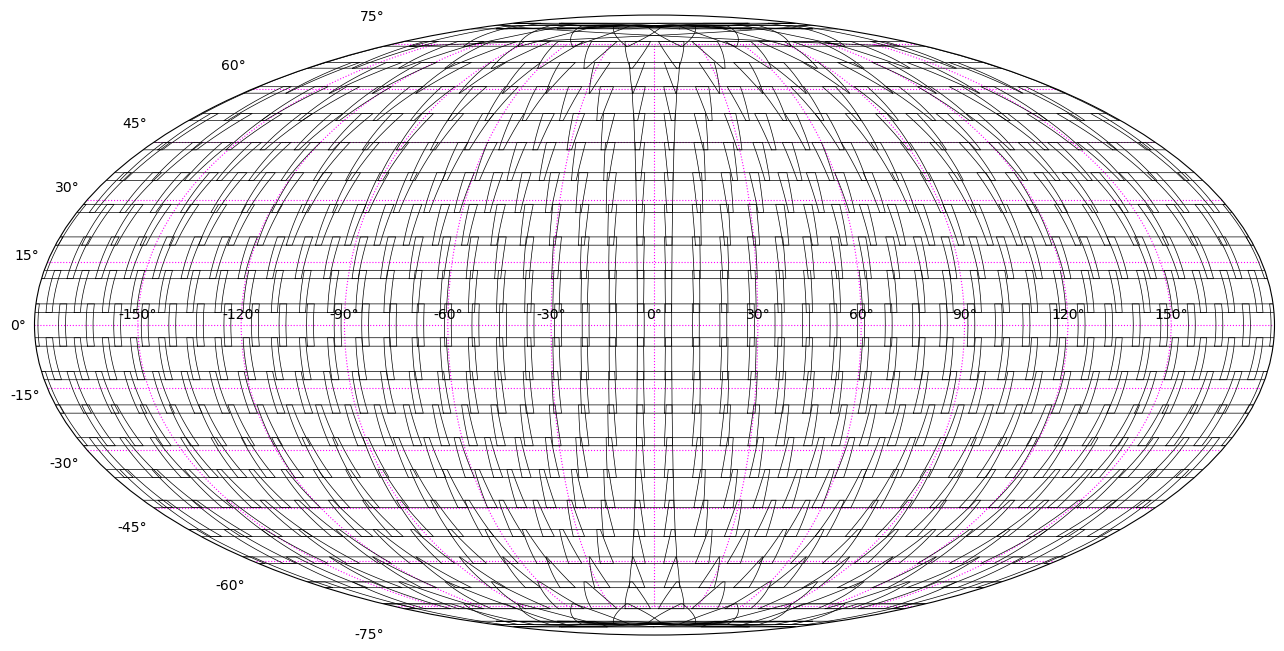

In [40]:
fig, ax = create_mollweide_figure()

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_mollweide(field, ax, color='k', ls='-', lw=0.5)

##### Avoid Galactic plane

We set a Galactic latitude limit, $b_\mathrm{lim}$, and reject all fields that lie within the Galactic plane according to this limit. We allow two approaches:

* Simple/fast approach: We reject fields when the center point is within $[-b_\mathrm{lim}, b_\mathrm{lim}]$. This approach requires only the fields' center points.
* Strict approach: We reject fields when *all four* corner points are within $[-b_\mathrm{lim}, b_\mathrm{lim}]$. This appraoch requires to calculate each field's corner points.

In [41]:
def avoid_galactic_plane(gal_lat_lim, center_ra, center_dec, fov=0., tilt=0., strict=False, verbose=0):
    
    # consider field centers:
    if not strict:
        coord = SkyCoord(center_ra, center_dec, unit='rad', frame='icrs')
        coord = coord.transform_to('galactic')
        sel = np.logical_or(coord.b.rad >= gal_lat_lim, coord.b.rad <= -gal_lat_lim)
        
        if verbose:
            print(f'Galactic latitude limit: +/-{np.degrees(gal_lat_lim):.1f} deg')
            print('Application: field centers')
            print(f'Fields removed:   {np.sum(~sel)}')
            print(f'Fields remaining: {np.sum(sel)}')
        
        return center_ra[sel], center_dec[sel]
    
    # consider field corners:
    else:
        sel = np.zeros(center_ra.shape[0], dtype=bool)
        fields = []
        
        for i, (ra, dec) in enumerate(zip(center_ra, center_dec)):
            corner_ra, corner_dec = field_corners(fov, ra=ra, dec=dec, tilt=tilt)
            coord = SkyCoord(corner_ra, corner_dec, unit='rad', frame='icrs')
            coord = coord.transform_to('galactic')
            
            if np.any(np.logical_or(coord.b.rad >= gal_lat_lim, coord.b.rad <= -gal_lat_lim)):
                sel[i] = True
                fields.append([corner_ra, corner_dec])

        if verbose:
            print(f'Galactic latitude limit: +/-{np.degrees(gal_lat_lim):.1f} deg')
            print('Application: field corners')
            print(f'Fields removed:   {np.sum(~sel)}')
            print(f'Fields remaining: {np.sum(sel)}')

        return center_ra[sel], center_dec[sel], fields

###### Demonstration of the simple approach - using the field centers

In [42]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-90.) # radians
gal_lat_lim = np.radians(30.) # radians

center_ra, center_dec = field_centers_eq(fov, overlap=overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=3)
center_ra, center_dec = avoid_galactic_plane(gal_lat_lim, center_ra=center_ra, center_dec=center_dec, verbose=1)

Number of declination circles: 23
Dec: -88.00 deg. Number of fields:    6
Dec: -80.00 deg. Number of fields:   10
Dec: -72.00 deg. Number of fields:   15
Dec: -64.00 deg. Number of fields:   19
Dec: -56.00 deg. Number of fields:   25
Dec: -48.00 deg. Number of fields:   30
Dec: -40.00 deg. Number of fields:   34
Dec: -32.00 deg. Number of fields:   38
Dec: -24.00 deg. Number of fields:   41
Dec: -16.00 deg. Number of fields:   43
Dec:  -8.00 deg. Number of fields:   44
Dec:  -0.00 deg. Number of fields:   45
Dec:  +8.00 deg. Number of fields:   44
Dec: +16.00 deg. Number of fields:   43
Dec: +24.00 deg. Number of fields:   41
Dec: +32.00 deg. Number of fields:   38
Dec: +40.00 deg. Number of fields:   34
Dec: +48.00 deg. Number of fields:   30
Dec: +56.00 deg. Number of fields:   25
Dec: +64.00 deg. Number of fields:   19
Dec: +72.00 deg. Number of fields:   15
Dec: +80.00 deg. Number of fields:   10
Dec: +88.00 deg. Number of fields:    6
Total number of fields: 655
Galactic latitude 

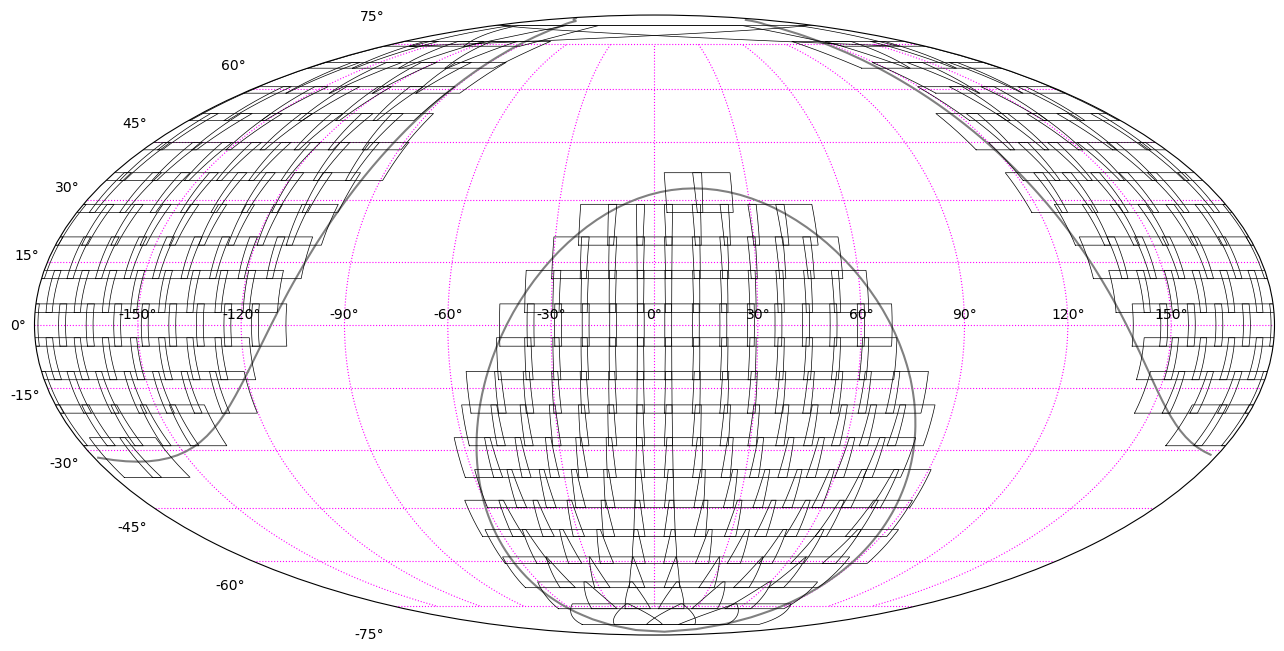

In [43]:
fig, ax = create_mollweide_figure()
plot_galactic_plane_mollweide(b_lim=30*u.deg, n=100)

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_mollweide(field, ax, color='k', ls='-', lw=0.5)

###### Demonstration of the strict approach - using the field corner points

In [44]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-90.) # radians
gal_lat_lim = np.radians(30.) # radians

center_ra, center_dec = field_centers_eq(fov, overlap=overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=3)
center_ra, center_dec, fields = avoid_galactic_plane(gal_lat_lim, center_ra=center_ra, center_dec=center_dec, fov=fov, strict=True, verbose=1)
print(center_ra.size)
print(len(fields))

Number of declination circles: 23
Dec: -88.00 deg. Number of fields:    6
Dec: -80.00 deg. Number of fields:   10
Dec: -72.00 deg. Number of fields:   15
Dec: -64.00 deg. Number of fields:   19
Dec: -56.00 deg. Number of fields:   25
Dec: -48.00 deg. Number of fields:   30
Dec: -40.00 deg. Number of fields:   34
Dec: -32.00 deg. Number of fields:   38
Dec: -24.00 deg. Number of fields:   41
Dec: -16.00 deg. Number of fields:   43
Dec:  -8.00 deg. Number of fields:   44
Dec:  -0.00 deg. Number of fields:   45
Dec:  +8.00 deg. Number of fields:   44
Dec: +16.00 deg. Number of fields:   43
Dec: +24.00 deg. Number of fields:   41
Dec: +32.00 deg. Number of fields:   38
Dec: +40.00 deg. Number of fields:   34
Dec: +48.00 deg. Number of fields:   30
Dec: +56.00 deg. Number of fields:   25
Dec: +64.00 deg. Number of fields:   19
Dec: +72.00 deg. Number of fields:   15
Dec: +80.00 deg. Number of fields:   10
Dec: +88.00 deg. Number of fields:    6
Total number of fields: 655
Galactic latitude 

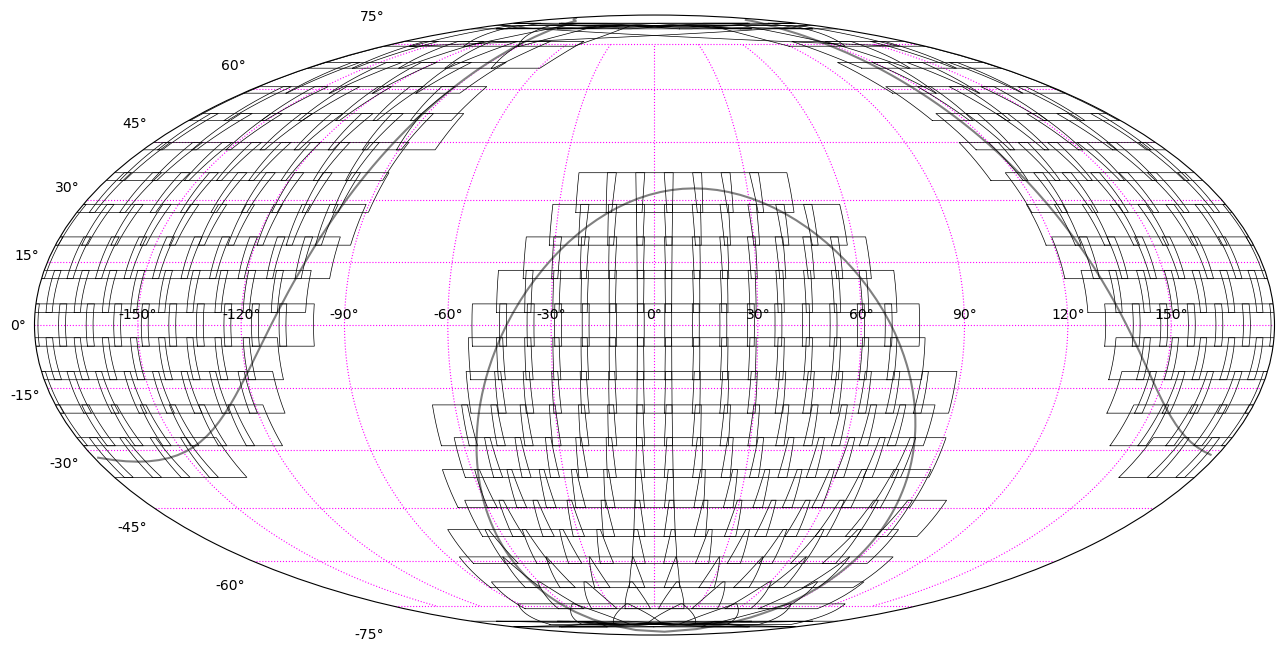

In [45]:
fig, ax = create_mollweide_figure()
plot_galactic_plane_mollweide(b_lim=30*u.deg, n=100)

for ra, dec in zip(center_ra, center_dec):
    field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
    plot_field_mollweide(field, ax, color='k', ls='-', lw=0.5)

#### Tilted great circle grid

**Grid layout:**

1. We split the RA range into equidistant steps, such that we get the targeted overlap between fields at the equator. The overlap at other declinations will be larger.
2. At each RA we split the declinations into equidistant steps at which we place fields.
3. We rotate the entire grid such that the poles - where the unwanted overlap between fields is the largest - are within the Galactic plane.
4. All fields are tilted back into the correct orientation.

##### Split declination range at fixed RA

We arange fields ranging from the South pole to the North pole, such that the lowest and highest field's edges touch the pole, not the field centers. In this setup $\pi = n(\mathrm{fov} - \mathrm{overlap}) + \mathrm{overlap}$. Accordingly, we need $n = \mathrm{ceil}\left(\frac{\pi - \mathrm{overlap}}{\mathrm{fov} - \mathrm{overlap}}\right)$ fields. Depending on the field of view and the overlap, the fraction may not yield an interger number, which is why we round up. In that case, the full declination range covered is $\Delta\delta^* = n (\mathrm{fov} - \mathrm{overlap}) + \mathrm{overlap} \geq \pi$. We do not care about the extension beyond the poles because those areas will be rotated into the Galatic plane later. When we split the extension equally between the South and North pole the extension is $\epsilon_\delta = (\Delta\delta^* - \pi) / 2$. We use $\epsilon_\delta$ as an offset to the field's center points. The declination of the lowest field's center point is $\delta_S = -\pi + \mathrm{fov}/2 - \epsilon_\delta$ and the declination of the highest field's center point is $\delta_N = \pi - \mathrm{fov}/2 + \epsilon_\delta$. With this approch we maintain the targeted overlap.

Number of RA steps: 23
Overlap used: 2.00 deg


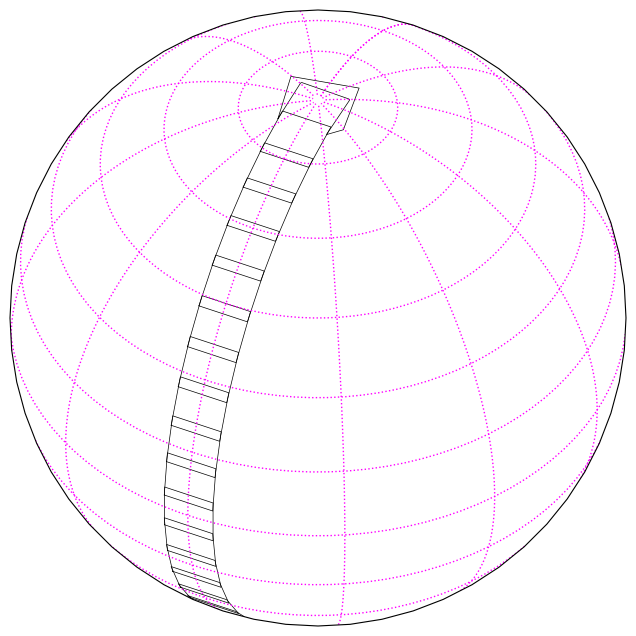

In [46]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians

n = int(np.ceil((np.pi - overlap) / (fov - overlap)))
offset = (n * (fov - overlap) + overlap - np.pi) / 2.
print(f'Number of RA steps: {n}')

dec0 = -np.pi / 2. + fov / 2. - offset
dec1 = +np.pi / 2. - fov / 2. + offset
decs = np.linspace(dec0, dec1, n)
overlap_used = fov - (decs[1] - decs[0])
print('Overlap used: {0:.2f} deg'.format(np.degrees(overlap_used)))

fig, ax = create_orthographic_figure(25, 45)

for dec in decs:
    field = field_corners(fov, ra=0, dec=dec, tilt=0.)
    plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

##### Split RA

We use the same formalism as above when we split the equator into different fields allowing for an overlap between neighboring fields.

If the overlap leads to an integer number of fields we use that number of fields. If the overlap does not result in an interger number, we use the next highest integer and increase the overlap accordingly. This way we equally distribute the overlap over all fields and do not end up with a much larger overlap between the pair of the first and last field around the equator. We split the RA range into $N = \mathrm{ceil}\left(\frac{2 \pi}{\mathrm{fov} - \mathrm{overlap}}\right)$ fields:

Number of RA steps: 45
Overlap used: 2.00 deg


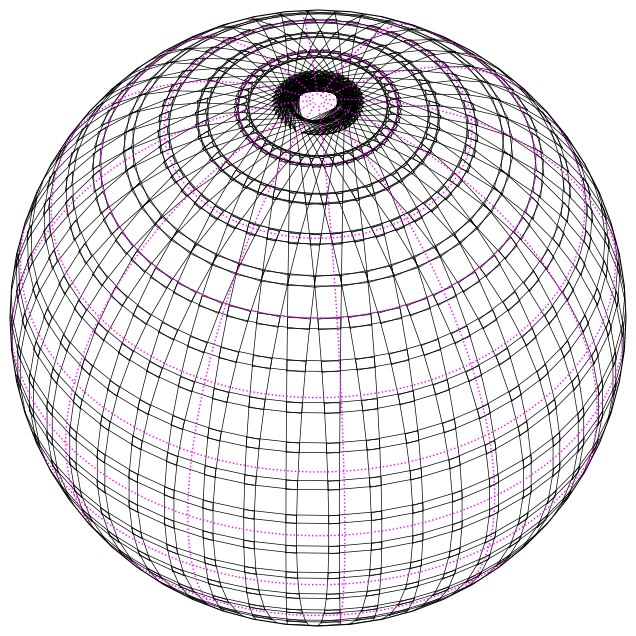

In [47]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians

n = int(np.ceil(2 * np.pi / (fov - overlap)))
print(f'Number of RA steps: {n}')

ras = np.linspace(0., 2.*np.pi, n+1)[:-1]
overlap_used = fov - (ras[1] - ras[0])
print('Overlap used: {0:.2f} deg'.format(np.degrees(overlap_used)))

fig, ax = create_orthographic_figure(25, 45)

for ra in ras:
    for dec in decs:
        field = field_corners(fov, ra=ra, dec=dec, tilt=0.)
        plot_field_orthographic(field, ax, color='k', ls='-', lw=0.5)

Up to this point we still have a isolatitudinal grid as the one we defined above. However, here each latitude is split into the same number of cells, resulting in much more redundant overlap of cells the closer we get to the poles.

##### Rotate the grid

<div class="alert alert-block alert-warning">
I am rotating twice. Once would be enough. I should also try this approach. Is there any gain in rotating the Equatorial grid? Maybe I should split these approaches up: Equatorial grid, Grand-Circle-Grid, rotating grids.
</div>

The above two steps gave us all right ascensions and all declinations. Now, we create a grid of all combinations. Then we transform to Cartesian coordinates, rotate the whole grid in two directions to move the poles into the galactic plane. Finally, we convert back to spherical coordinates:

In [48]:
ras_grid, decs_grid = np.meshgrid(ras, decs)
ras_grid = ras_grid.flatten()
decs_grid = decs_grid.flatten()
x, y, z = sphere_to_cart(ras_grid, decs_grid)
#x, y, z = rot_dec(x, y, z, np.radians(-30.))
x, y, z = rot_dec(x, y, z, np.pi/2.)
x, y, z = rot_ra(x, y, z, np.radians(110))
ras_rot, decs_rot, __ = cart_to_sphere(x, y, z)

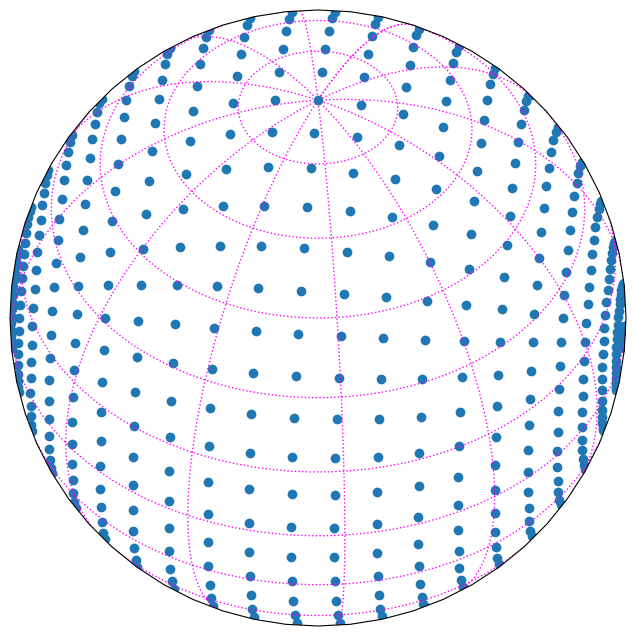

In [49]:
fig, ax = create_orthographic_figure(25, 45)
ax.plot(np.degrees(ras_rot), np.degrees(decs_rot), transform=ccrs.PlateCarree(), marker='o', linestyle='None');

In [50]:
center_ra, center_dec, fields = avoid_galactic_plane(gal_lat_lim, ras_rot, decs_rot, fov=fov, tilt=0., strict=True, verbose=3)

Galactic latitude limit: +/-30.0 deg
Application: field corners
Fields removed:   559
Fields remaining: 476


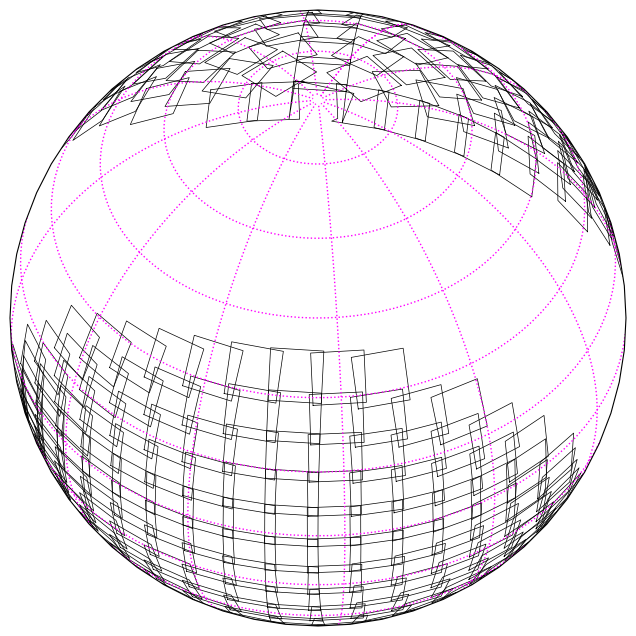

In [51]:
fig, ax = create_orthographic_figure(25, 45)

plot_field_orthographic(fields, ax, color='k', ls='-', lw=0.5)

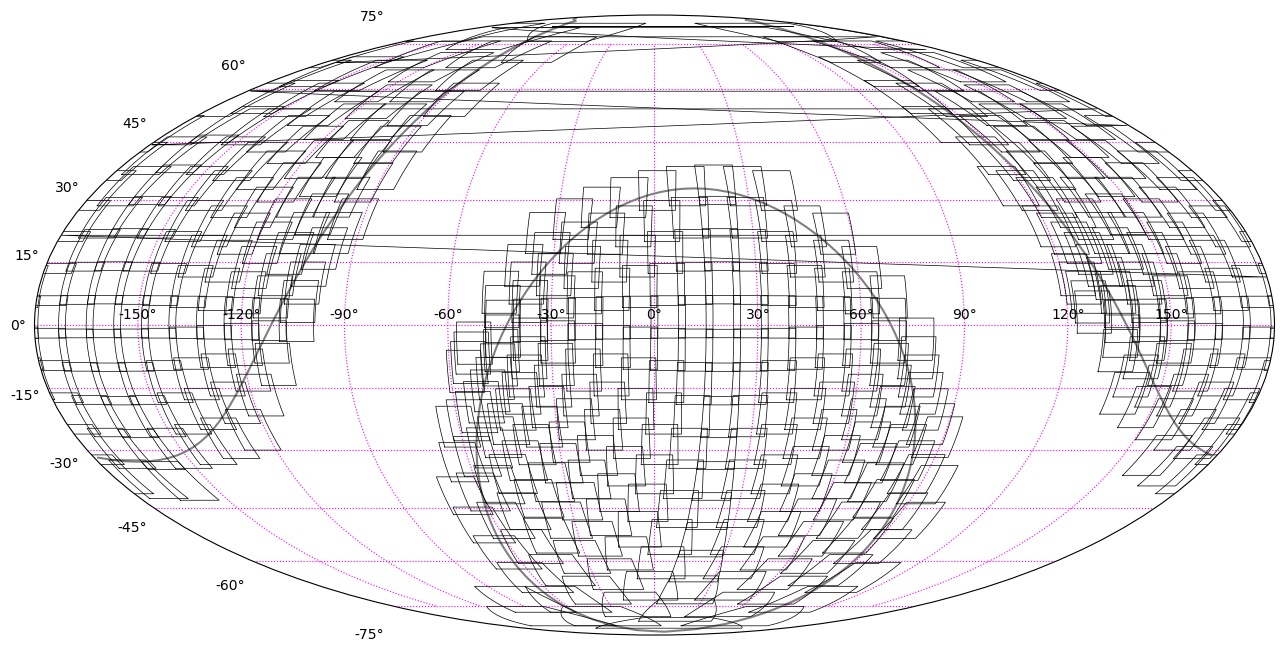

In [52]:
fig, ax = create_mollweide_figure()
plot_galactic_plane_mollweide(b_lim=30*u.deg, n=100)
plot_field_mollweide(fields, ax, color='k', ls='-', lw=0.5)

Visually, we can already make two agruments against this grid:
1. Moving the initial poles, where the overlap becomes extreme, into the Galactic plane does not get rid of the issue with too much overlap. 
2. The orientation of the fields at any latitude, and thus also near the poles, is fixed by the instrument. However the positions of the fields near the poles are not optimised to take that into account. There are obvious gaps. Closing them will not be a straight forward as with the isolatitudinal grid.

### Test setup

We need to test whether a grid has any holes and what the actual amount of overlap is in total and between specific fields.
We use a random sampling approach for that. We randomly sample a point on the sphere and then check in which fields it is located. A point in no field identifies a gap in the grid. A points in multiple fields identifies an overlapping region.

We apply two different sampling approaches for two different use cases.

#### Random sampling on a sphere - uniformly distributed

We want to estimate what fraction of the sky is covered by a single field, what fraction is covered by multiple fields, and how much is not covered, i.e. consists of gaps in the grid. For this application we want the points to be sampled with uniform probability on each part of the sky. We do that by sampling points from a 3D Gaussian distribution and projecting them on the unit sphere.

First we define a function to randomly sample points on the sphere, then we extend it to allow us setting declination limits and a limit on the Galactic latitude:

In [53]:
def _sample_spherical(n_points, ndim=3):
    vec = np.random.randn(ndim, n_points)
    vec /= np.linalg.norm(vec, axis=0)
    ra, dec, __ = cart_to_sphere(vec[0], vec[1], vec[2])
    return ra, dec

In [54]:
def sample_spherical(n_points, dec_lim_north=np.pi/2, dec_lim_south=-np.pi/2, gal_lat_lim=0.):
    ra = []
    dec = []
    n_needed = n_points
    
    while True:
        more_ra, more_dec = _sample_spherical(n_points)
        sel = np.logical_and(more_dec >= dec_lim_south, more_dec <= dec_lim_north)
        more_ra = more_ra[sel]
        more_dec = more_dec[sel]
        
        if gal_lat_lim > 0.:
            more_ra, more_dec = avoid_galactic_plane(gal_lat_lim, center_ra=more_ra, center_dec=more_dec)
            
        more_ra = more_ra[:n_needed]
        more_dec = more_dec[:n_needed]                                 
        ra.append(more_ra)
        dec.append(more_dec)
        n_needed -= more_ra.shape[0]

        if n_needed < 1:
            break
    
    ra = np.concatenate(ra)
    dec = np.concatenate(dec)
    
    return ra, dec

10000


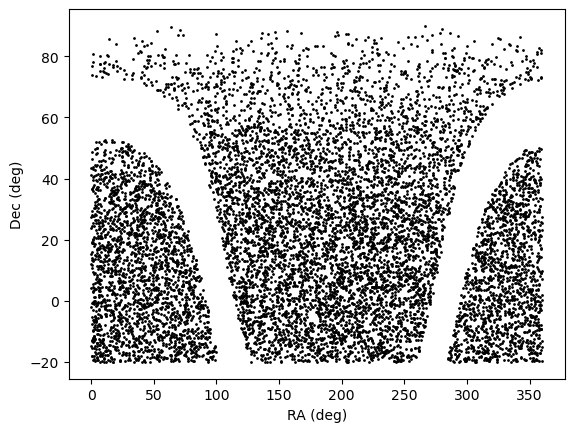

In [55]:
n = 10000
dec_lim_north = np.radians(90) # radians
dec_lim_south = np.radians(-20) # radians
gal_lat_lim = np.radians(10) # radians
random_ras, random_decs = sample_spherical(n, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, gal_lat_lim=gal_lat_lim)
plt.plot(np.degrees(random_ras), np.degrees(random_decs), marker='o', ms=1, color='k', ls='None')
plt.ylabel('Dec (deg)')
plt.xlabel('RA (deg)')
print(random_ras.shape[0])

#### Random sampling on a sphere - increase sampling towards the poles

If we create a grid with very small gaps, the probability of sampling random points in those gaps is small. To idnetify gaps we need a large amount of random samples. Gaps are most likely to occur near the poles. Therefore, we use a second approach, in which we increase the number of random samples towards the poles. This is easily done by uniformly drawing random numbers in the RA-dec space. Note that this approach cannot be used to estimate the fraction of sky covered by one, multiple, or no fields.

In [56]:
def sample_radec(n_points, dec_lim_north=np.pi/2, dec_lim_south=-np.pi/2, gal_lat_lim=0.):
    ra = []
    dec = []
    n_needed = n_points
    
    while True:
        more_ra = np.random.uniform(0, 2. * np.pi, n_points)
        more_dec = np.random.uniform(dec_lim_south, dec_lim_north, n_points)
        
        if gal_lat_lim > 0.:
            more_ra, more_dec = avoid_galactic_plane(gal_lat_lim, center_ra=more_ra, center_dec=more_dec)
            
        more_ra = more_ra[:n_needed]
        more_dec = more_dec[:n_needed] 
        ra.append(more_ra)
        dec.append(more_dec)
        n_needed -= more_ra.shape[0]

        if n_needed < 1:
            break
    
    ra = np.concatenate(ra)
    dec = np.concatenate(dec)
    
    return ra, dec

10000


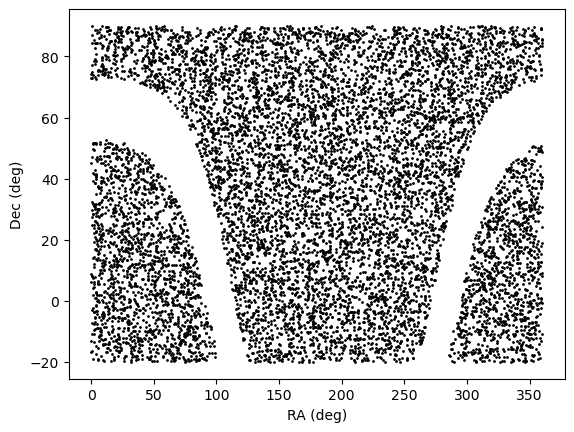

In [57]:
n = 10000
dec_lim_north = np.radians(90) # radians
dec_lim_south = np.radians(-20) # radians
gal_lat_lim = np.radians(10) # radians
random_ras, random_decs = sample_radec(n, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, gal_lat_lim=gal_lat_lim)
plt.plot(np.degrees(random_ras), np.degrees(random_decs), marker='o', ms=1, color='k', ls='None')
plt.ylabel('Dec (deg)')
plt.xlabel('RA (deg)')
print(random_ras.shape[0])

#### Test if point is in field

To check whether a point is in a field we use the functions from `Develop_WALOPS_constraints_v2.ipynb` that allow to test whether a point is within a polygon. Here the polygon is defined by the four corner points of a field.

In [58]:
def orientation(p, q0, q1):
    return np.sign((q1[0] - q0[0]) * (p[1] - q0[1]) - (p[0] - q0[0]) * (q1[1] - q0[1]))

In [59]:
def crossing(p, q0, q1):
    p_heq_q0 = q0[1] <= p[1]
    p_heq_q1 = q1[1] <= p[1]
    p_left = orientation(p, q0, q1)
    
    if p_heq_q0 and ~p_heq_q1 and p_left > 0:
        cross = +1
    elif ~p_heq_q0 and p_heq_q1 and p_left < 0:
        cross = -1
    else:
        cross = 0
    
    return cross

In [60]:
def inside_polygon(point, polygon):
    polygon = np.array(polygon + [polygon[0]])
    
    winding_number = 0
    
    for q0, q1 in zip(polygon[0:-1], polygon[1:]):
        winding_number += crossing(point, q0, q1)
    
    return winding_number > 0

The test whether a point is in a field does not work easily in the RA-dec space, because the field edges are not linear. Especially at the poles this becomes critical. Only fields with a center point on the equator have linear upper and lower edges, where four points are sufficent to describe the fields outline as a polygon. Therefore, we rotate the frame such that we move the field back to the origin. We use the RA and declination of the field center point, to rotate our reference frame for the field and the point. Then we can use the four corner points with the `inside_polygon()` function defined above.

In [61]:
def inside_field(point, field_center, field_corners):
    
    center_ra = field_center[0]
    center_dec = field_center[1]
    corner_ras = field_corners[0]
    corner_decs = field_corners[1]
    point_ra = point[0]
    point_dec = point[1]
    
    # rotate frame for field corners:
    x, y, z = sphere_to_cart(corner_ras, corner_decs)
    x, y, z = rot_ra(x, y, z, -center_ra)
    x, y, z = rot_dec(x, y, z, -center_dec)
    corner_ras_rot, corner_decs_rot, __ = cart_to_sphere(x, y, z)
    
    # RA wrap first and last corner point:
    corner_ras_rot[0] -= 2. * np.pi
    corner_ras_rot[3] -= 2. * np.pi
    
    # rotate frame for point:
    x, y, z = sphere_to_cart(point_ra, point_dec)
    x, y, z = rot_ra(x, y, z, -center_ra)
    x, y, z = rot_dec(x, y, z, -center_dec)
    point_ra_rot, point_dec_rot, __ = cart_to_sphere(x, y, z)
    
    polygon = [[ra, dec] for ra, dec in zip(corner_ras_rot, corner_decs_rot)]
    is_inside = inside_polygon((point_ra_rot, point_dec_rot), polygon)
    
    return is_inside

Next we will do two improvements.

First, the rotations of the field corner points are actually unnecessary. They add a lot of calculations that are not needed. Each field will be rotate back to its position at initialization. Rather than rotating all fields back, when we test a point against all fields, we can simply initialize one new field once. We just need to make sure that we use the same field of view and tilt as in the grid that we are testing.

Second, we do not have to test a point against every field. Most fields will be far too off from the point that we do not need to apply the `inside_polygon()`. We will first filter out all fields that have a center point separated by more than $\sqrt{2}\,\mathrm{FoV}$ from the point and then run the `inside_polygon()` function only on the remaining cases.

We write up everything in one function below.

#### Test function

In [62]:
def test_grid(sampler, fov, tilt, center_ras, center_decs, n_points=1000, dec_lim_north=np.pi/2, dec_lim_south=-np.pi/2, gal_lat_lim=0.):
    # create test points:
    print(f'Creating {n_points} test points..')
    points_ra, points_dec = sampler(n_points, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, gal_lat_lim=gal_lat_lim)
    points_coord = SkyCoord(points_ra, points_dec, unit='rad')
    points_associations = [[] for i in range(n_points)]
    
    # create initial field corners:
    corner_ras, corner_decs = field_corners(fov, ra=0., dec=0., tilt=tilt)
    corner_ras[0] -= 2. * np.pi
    corner_ras[3] -= 2. * np.pi
    polygon = [[ra, dec] for ra, dec in zip(corner_ras, corner_decs)]
    
    # iterate through fields:
    center_coord = SkyCoord(center_ras, center_decs, unit='rad')
    n_fields = center_coord.shape[0]
    print(f'Iterate through {n_fields} fields..')
    
    for i, coord in enumerate(center_coord):
        print(f'\r  Field {i+1} of {n_fields} ({i/n_fields*100:.1f}%)..', end='')
        
        # identify close points:
        close = coord.separation(points_coord).rad < np.sqrt(2) * fov
        i_close = np.nonzero(close)[0]
        
        # iterate through close points:
        for j in i_close:
            point_ra = points_ra[j]
            point_dec = points_dec[j]
            
            # rotate frame for point:
            x, y, z = sphere_to_cart(point_ra, point_dec)
            x, y, z = rot_ra(x, y, z, -coord.ra.rad)
            x, y, z = rot_dec(x, y, z, -coord.dec.rad)
            point_ra_rot, point_dec_rot, __ = cart_to_sphere(x, y, z)
            if point_ra_rot > np.pi:
                point_ra_rot -= 2. * np.pi
            
            # check if point is in field:
            inside = inside_polygon((point_ra_rot, point_dec_rot), polygon)
            
            # store result:
            if inside:
                points_associations[j].append(i)
        
    print('\rFinish results..              ')
    
    # count associations:
    n_associations = [len(field_ids) for field_ids in points_associations]
    
    points = pd.DataFrame({'ra': points_ra, 'dec': points_dec, 'n_fields': n_associations, 'field_ids': points_associations})
    print('Done.')
    
    return points

Run a test test:

In [63]:
fov = np.radians(10.) # radians
tilt = np.radians(0.) # radians
overlap = np.radians(2.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-25.) # radians
gal_lat_lim = np.radians(20.) # radians

center_ra, center_dec = field_centers_eq(fov, overlap=overlap, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, verbose=3)
center_ra, center_dec, __ = avoid_galactic_plane(gal_lat_lim, center_ra=center_ra, center_dec=center_dec, fov=fov, strict=True, verbose=1)
fields = [field_corners(fov, ra=ra, dec=dec, tilt=0.) for ra, dec in zip(center_ra, center_dec)]

Number of declination circles: 15
Dec: -23.50 deg. Number of fields:   41
Dec: -15.50 deg. Number of fields:   43
Dec:  -7.50 deg. Number of fields:   44
Dec:  +0.50 deg. Number of fields:   44
Dec:  +8.50 deg. Number of fields:   44
Dec: +16.50 deg. Number of fields:   43
Dec: +24.50 deg. Number of fields:   40
Dec: +32.50 deg. Number of fields:   37
Dec: +40.50 deg. Number of fields:   34
Dec: +48.50 deg. Number of fields:   29
Dec: +56.50 deg. Number of fields:   24
Dec: +64.50 deg. Number of fields:   19
Dec: +72.50 deg. Number of fields:   15
Dec: +80.50 deg. Number of fields:   10
Dec: +88.50 deg. Number of fields:    5
Total number of fields: 472
Galactic latitude limit: +/-20.0 deg
Application: field corners
Fields removed:   99
Fields remaining: 373


In [64]:
test_points = test_grid(
        sample_spherical, fov, tilt, center_ra, center_dec,
        dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, gal_lat_lim=gal_lat_lim, n_points=200)

Creating 200 test points..
Iterate through 373 fields..
Finish results..              
Done.


In [65]:
test_points

ra       dec  n_fields   field_ids
0    0.253027 -0.050594         2   [70, 108]
1    3.085132  0.306060         1       [197]
2    2.395387 -0.180888         1        [82]
3    2.347118 -0.017277         2  [118, 119]
4    5.992292  0.138398         1       [178]
..        ...       ...       ...         ...
195  3.446594  0.647560         2  [265, 292]
196  5.096818  1.379748         1       [366]
197  2.217786  0.483694         2  [226, 258]
198  3.772872  0.661026         2  [293, 294]
199  4.668265  1.032503         1       [331]

[200 rows x 4 columns]

In [66]:
n_colors = 3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[cms.apple_r(i/n_colors) for i in range(1, n_colors+1)])

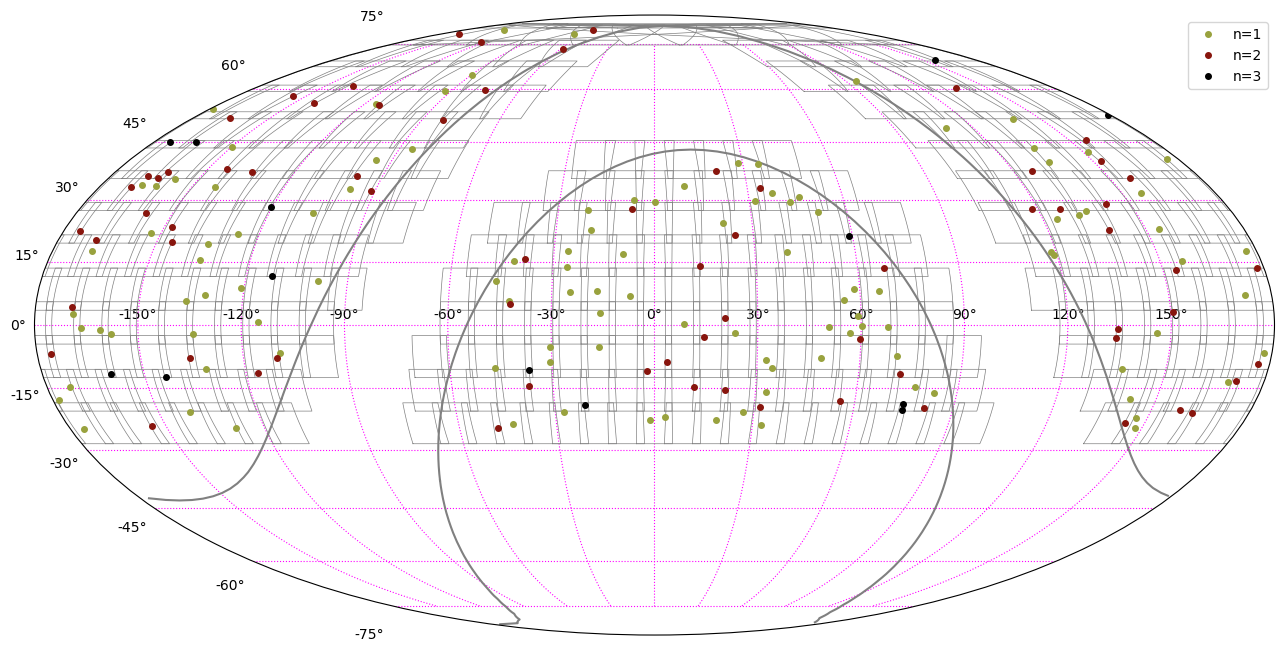

In [67]:
fig, ax = create_mollweide_figure()
plot_field_mollweide(fields, ax, color='0.5', ls='-', lw=0.5)
plot_galactic_plane_mollweide(b_lim=gal_lat_lim*u.rad)
                              
for i in range(3):
    sel = test_points['n_fields'] == i + 1
    ax.plot(np.where(test_points.loc[sel, 'ra']>np.pi, test_points.loc[sel, 'ra']-2*np.pi, test_points.loc[sel, 'ra']),
            test_points.loc[sel, 'dec'], ls='None', marker='o', ms=4, label=f'n={i+1}')
plt.legend();

#### Test summary

Run a test to test the function that summarize the test results:

In [68]:
n_points = 20000
test_points = test_grid(
        sample_spherical, fov, tilt, center_ra, center_dec,
        dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south, gal_lat_lim=gal_lat_lim, n_points=n_points)

Creating 20000 test points..
Iterate through 373 fields..
Finish results..              
Done.


Get a test summary:

In [69]:
def test_summary(test_points):
    fraction_one_field = np.sum(test_points['n_fields'] == 1) / test_points.shape[0]
    fraction_overlap = np.sum(test_points['n_fields'] > 1) / test_points.shape[0]
    fraction_overlap_2 = np.sum(test_points['n_fields'] == 2) / test_points.shape[0]
    fraction_overlap_3 = np.sum(test_points['n_fields'] == 3) / test_points.shape[0]
    fraction_overlap_4 = np.sum(test_points['n_fields'] == 4) / test_points.shape[0]
    fraction_gaps = np.sum(test_points['n_fields'] == 0) / test_points.shape[0]
    gaps_exist = np.any(test_points['n_fields'] == 0)
    
    print(f'Fraction of sky, non-overlapping field region: {fraction_one_field*100:4.1f} %')
    print(f'Fraction of sky, overlapping field regions:    {fraction_overlap*100:4.1f} %')
    print(f'Fraction of sky, 2 fields overlapping:         {fraction_overlap_2*100:4.1f} %')
    print(f'Fraction of sky, 3 fields overlapping:         {fraction_overlap_3*100:4.1f} %')
    print(f'Fraction of sky, 4 fields overlapping:         {fraction_overlap_4*100:4.1f} %')
    print(f'Fraction of gaps:                              {fraction_gaps:8.1e}')
    if gaps_exist:
        print('WARNING: Gaps exist!')
        
    return test_points['n_fields'].value_counts()

In [70]:
counts = test_summary(test_points)
counts

Fraction of sky, non-overlapping field region: 57.0 %
Fraction of sky, overlapping field regions:    43.0 %
Fraction of sky, 2 fields overlapping:         33.6 %
Fraction of sky, 3 fields overlapping:          6.5 %
Fraction of sky, 4 fields overlapping:          2.6 %
Fraction of gaps:                               0.0e+00


1    11396
2     6711
3     1295
4      521
5       74
6        3
Name: n_fields, dtype: int64

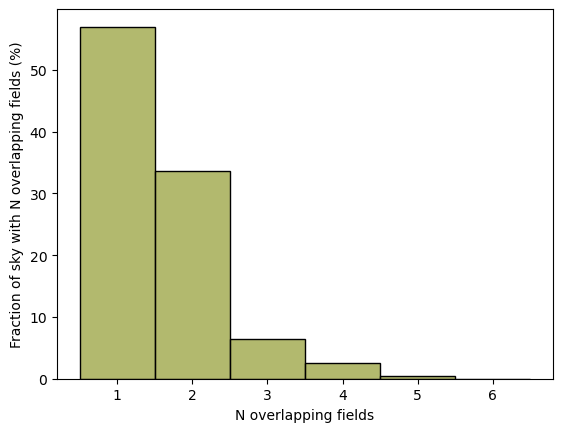

In [71]:
sns.histplot(test_points, x='n_fields', discrete=True, stat='percent')
plt.xlabel('N overlapping fields')
plt.ylabel('Fraction of sky with N overlapping fields (%)');
#plt.yscale('log');

In [72]:
sel = test_points['n_fields'] == 5
test_points.loc[sel]

ra       dec  n_fields                  field_ids
372    2.135072  1.512463         5  [368, 369, 370, 371, 372]
478    4.964518  1.524553         5  [368, 369, 370, 371, 372]
738    1.870035  1.513715         5  [368, 369, 370, 371, 372]
1261   1.196861  1.506448         5  [368, 369, 370, 371, 372]
1371   3.081877  1.467727         5  [362, 363, 364, 370, 371]
...         ...       ...       ...                        ...
17274  1.552623  1.513747         5  [368, 369, 370, 371, 372]
17313  5.399515  1.477477         5  [366, 367, 368, 369, 372]
17548  3.232857  1.519777         5  [368, 369, 370, 371, 372]
18747  2.280868  1.552868         5  [368, 369, 370, 371, 372]
19479  3.085620  1.511323         5  [368, 369, 370, 371, 372]

[74 rows x 4 columns]

Identify the gaps:

In [73]:
def find_gaps(test_points):
    sel = test_points['n_fields'] == 0
    return test_points.loc[sel, ('ra', 'dec')].reset_index(drop=True)

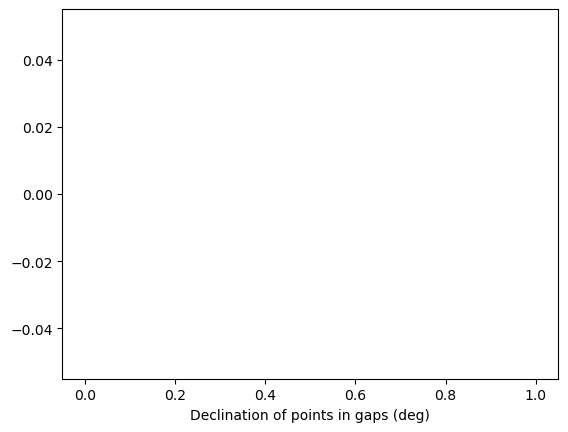

In [74]:
gaps = find_gaps(test_points)
plt.hist(np.degrees(gaps['dec']))
plt.xlabel('Declination of points in gaps (deg)');

## Module implementation

I implemented all of the above in the `fieldgrid` module:

In [76]:
import fieldgrid

### Isolatitudinal grid class

From this module we can create the isolatitudinal field grid by creating an instance of the `FieldGridIsoLat` class:

In [77]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
tilt = np.radians(0.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-25.) # radians
gal_lat_lim = np.radians(20.) # radians
gal_lat_lim_strict = True
verbose = 2

grid = fieldgrid.FieldGridIsoLat(
        fov, overlap=overlap, tilt=tilt, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south,
        gal_lat_lim=gal_lat_lim, gal_lat_lim_strict=gal_lat_lim_strict, verbose=verbose)

Create fields..
  Calculate field centers..
    Number of declination circles: 15
    Dec: -23.50 deg. Number of fields:     41
    Dec: -15.50 deg. Number of fields:     43
    Dec:  -7.50 deg. Number of fields:     44
    Dec:  +0.50 deg. Number of fields:     44
    Dec:  +8.50 deg. Number of fields:     44
    Dec: +16.50 deg. Number of fields:     43
    Dec: +24.50 deg. Number of fields:     40
    Dec: +32.50 deg. Number of fields:     37
    Dec: +40.50 deg. Number of fields:     34
    Dec: +48.50 deg. Number of fields:     29
    Dec: +56.50 deg. Number of fields:     24
    Dec: +64.50 deg. Number of fields:     19
    Dec: +72.50 deg. Closing gaps. Number of fields:     15
    Dec: +80.50 deg. Closing gaps. Number of fields:     10
    Dec: +88.50 deg. Closing gaps. Number of fields:      5
  Calculate field corners..
    Done                                                    
  Identify fields in Galactic plane..
    Galactic latitude limit: +/-20.0 deg
    Application: f

### Tilted great circle grid class

Similarly we can create the tilted great circle grid by creating an instance of the `FieldGridGrtCirc` class:

In [78]:
fov = np.radians(10.) # radians
overlap = np.radians(2.) # radians
tilt = np.radians(0.) # radians
dec_lim_north = np.radians(90.) # radians
dec_lim_south = np.radians(-25.) # radians
gal_lat_lim = np.radians(20.) # radians
gal_lat_lim_strict = False
frame_rot_dec = np.radians(90.) # radians
frame_rot_ra = np.radians(110.) # radians
verbose = 2

grid = fieldgrid.FieldGridGrtCirc(
        fov, overlap=overlap, tilt=tilt, dec_lim_north=dec_lim_north, dec_lim_south=dec_lim_south,
        gal_lat_lim=gal_lat_lim, gal_lat_lim_strict=gal_lat_lim_strict, 
        frame_rot_ra=frame_rot_ra, frame_rot_dec=frame_rot_dec, verbose=verbose)

Create fields..
  Calculate field centers..
    Number of RA half circles: 45
    Number of declinations: 23
    Rotate frame by 90.0 deg in declination
    Rotate frame by 110.0 deg in RA
  Calculate field corners..
    Done                                                    
  Identify fields in Galactic plane..
    Galactic latitude limit: +/-20.0 deg
    Application: field centers
    Fields removed:   506
    Fields remaining: 529
  Apply declination limits..
    Dec. lim. North: none
    Dec. lim. South: -25.0
    Fields removed:      129
    Fields remaining:    400
Final number of fields: 400


We know already from the tests above that the great circle grid is not useful. However, I still implemented it, because then I can demonstrate in what respects it does not work, using the testing class.

### Test class

The `skyfields` modul additionally includes the `FieldGridTester` class which can be used to test the grids. The class provides two samplers. We set the sampler at initialization of an instance.

#### Spherical sampler

With `sampler='spherical'` test points are randomly chosen uniformly on the unit sphere:

In [79]:
tester = fieldgrid.FieldGridTester(grid, sampler='spherical')

In [80]:
tester.test(1000)

Test points requested:   1000
Test points stored:         0
Test points needed:      1000
Sample test points..
Identify test point field associations..
  Done.                                          


True

Uniform sampling of the sphere allows us to estimate what fraction of the sky has gaps, is covered by a single field, or multiple fields.
We can get a quick summary of these results as follows. By default (`get=False`) only the most relevant information is printed, no data is returned. By setting `get=True`, the results are returned as `dict` which we can easily convert to a `pandas.DataFrame` for nicer presentation. 

In [81]:
fractions = pd.DataFrame(tester.summary(get=True))
print()
fractions

Sky fraction with gaps:                 1.4e-02
Sky fraction with single field:        36.2 %
Sky fraction with overlapping fields:  62.4 %



region  n_points  fraction
0                  gaps        14     0.014
1          single field       362     0.362
2  2 fields overlapping       433     0.433
3  3 fields overlapping       114     0.114
4  4 fields overlapping        61     0.061
5  5 fields overlapping        14     0.014

If we want to work further with the test points, we can get them with the following method, which again returns a `dict` that we convert in a `pandas.DataFrame`. This lists every test point, its RA and dec, the number of fields it is located in, and gives the IDs to those fields:

In [82]:
pd.DataFrame(tester.get_results())

ra       dec  n_fields             field_ids
0    3.805635 -0.197462         1                 [252]
1    3.266055  0.096106         4  [154, 155, 178, 179]
2    3.848420  1.069249         2            [218, 219]
3    4.382865 -0.166903         2            [344, 345]
4    2.445626  1.183021         2            [121, 145]
..        ...       ...       ...                   ...
995  2.168897  1.017993         1                  [98]
996  3.661174  0.679559         1                 [221]
997  3.802474  0.981876         1                 [219]
998  6.051643 -0.146696         2            [302, 303]
999  2.851491  0.138841         2             [83, 107]

[1000 rows x 4 columns]

Of course, more samples give better estimates. Therefore, we can always increase the number of samples:

In [83]:
tester.test(2000)

Test points requested:   2000
Test points stored:      1000
Test points needed:      1000
Sample test points..
Identify test point field associations..
  Done.                                          


True

#### Radec sampler

With `sampler='radec'` test points are randomly sampled uniformly in the RA-dec plane. On the sphere points will be more dense closer to the poles. This non-uniform sampling on the sphere does not allow us to estimate fractions of gaps, single, or multiple field coverage as above. Instead it allows us to better identify gaps. Gaps are more likely to occure near the poles. Therefore, it is useful to increase the number of samples towards the poles. 

In [84]:
tester = fieldgrid.FieldGridTester(grid, sampler='radec')
tester.test(1000)

Test points requested:   1000
Test points stored:         0
Test points needed:      1000
Sample test points..
Identify test point field associations..
  Done.                                          


True

When we call the summary, this time we do not get estimates of the fractions. We just get a statement how many points are located in gaps. With `get=True` we get the coordinates of all test points in gaps:

In [85]:
gaps = pd.DataFrame(tester.summary(get=True))
print()
gaps

Gaps found: 18



ra       dec
0   1.450653  1.351219
1   0.385637  1.474922
2   5.489839  1.358841
3   5.595694  1.387481
4   0.244129  1.479434
5   4.244537 -0.402026
6   0.599302  1.442218
7   5.732936  0.483049
8   1.180202  1.419394
9   6.227270  1.473394
10  1.780209  0.883283
11  1.144792  1.399828
12  5.853496  1.417878
13  2.917435  1.161724
14  1.040111  1.448752
15  1.379479  1.374212
16  0.690109  1.442715
17  0.697620  1.472121

## Pasiphae grid tests

We are going to test the setup of the real Pasiphae survey grids in the `Test_FieldGrid.ipynb` notebook.